In [1]:
import super_gradients

The console stream is logged into C:\Users\dpatricio\sg_logs\console.log


[2023-10-31 17:49:05] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-10-31 17:49:08] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-10-31 17:49:08,267] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-10-31 17:50:14] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-31 17:50:14] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-31 17:50:14] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-10-31 17:50:14] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [2]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

In [3]:
model = models.get(Models.YOLO_NAS_S, num_classes=3)

In [4]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from torchvision import transforms, utils
import numpy as np
import glob
import random


class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.lower()

        assert self.split in {'train', 'test'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        # with open(os.path.join(data_folder, self.split + '.txt'), 'r') as j:
        #     self.images = j.readlines()
        self.images = glob.glob(data_folder+"images/"+self.split+"/"+"*.jpg")
        self.images = [i.replace("\\","/") for i in self.images]
        self.images = random.sample(self.images,20)

    def __getitem__(self, i):
        # Read image and label
        image = Image.open(self.images[i].replace("\n","").replace("\\","/"), mode='r').resize((320, 320))
        image = image.convert("RGB")
        # image_tensor = torch.tensor(np.expand_dims(image,axis=-1)).permute(2, 0, 1).float()
        image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).float()
        labels = np.loadtxt(self.images[i].replace("jpg","txt").replace("images", "labels"))
        if len(labels.shape) == 1:
            labels = np.transpose(np.expand_dims(labels,axis=-1))
        return image_tensor, torch.tensor(labels,dtype=torch.float)
        

    def __len__(self):
        return len(self.images)

In [6]:
train_dataset = CustomDataset("dataset_deteccao/axial_t1wce_2_class_corrigida/",split="train")
val_dataset = CustomDataset("dataset_deteccao/axial_t1wce_2_class_corrigida/",split="test")

In [7]:
from torch.utils.data import Dataset, DataLoader
from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=DetectionCollateFN())
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN())

In [8]:
from super_gradients.training import training_hyperparams

from prettyformatter import pprint

train_params = training_hyperparams.get('coco2017_yolo_nas_s')
print('Training parameters:')
pprint(train_params, json=True)

In [9]:
train_params['max_epochs'] = 1
# train_params['lr_warmup_epochs'] = 0
# train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = 3
# train_params['average_best_models'] = False
# train_params['initial_lr'] = 0.01
# train_params['cosine_final_lr_ratio'] = 0.9
# train_params['mixed_precision'] = False
# train_params['phase_callbacks'] = []
# train_params['lr_warmup_steps'] = 10
# train_params['valid_metrics_list'] = [{"DetectionMetrics": {"post_prediction_callback": super_gradients.training.utils.ssd_utils.SSDPostPredictCallback(), "num_cls": 3}}]

In [36]:
pprint(train_params, json=True)

{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 0,
    "lr_warmup_steps"   : 1000,
    "lr_cooldown_epochs": 0,
    "warmup_initial_lr" : 1e-06,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.1,
    "warmup_mode"       : "LinearBatchLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "AdamW",
    "optimizer_params"  : {"weight_decay": 1e-05},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "PPYoloELoss",
    "criterion_params"  : {"use_static_assigner": false, "num_classes": 3, "reg_max": 16},
    "ema"       : true,
    "ema_params": {"decay": 0.9997, "decay_type": "threshold", "beta": 15},
    "train_metrics_list": [],
    "valid_metrics_list":
        [
    

In [11]:
from super_gradients.training import Trainer, MultiGPUMode

In [12]:
CHECKPOINT_DIR = '.'

In [13]:
super_gradients.setup_device(num_gpus=0)

Training parameters:
{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 0,
    "lr_warmup_steps"   : 1000,
    "lr_cooldown_epochs": 0,
    "warmup_initial_lr" : 1e-06,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.1,
    "warmup_mode"       : "LinearBatchLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "AdamW",
    "optimizer_params"  : {"weight_decay": 1e-05},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "PPYoloELoss",
    "criterion_params"  : {"use_static_assigner": false, "num_classes": 80, "reg_max": 16},
    "ema"       : true,
    "ema_params": {"decay": 0.9997, "decay_type": "threshold", "beta": 15},
    "train_metrics_list": [],
    "valid_metrics

[2023-10-31 17:50:17] WARNING - distributed_training_utils.py - CUDA device is not available on your device... Moving to CPU.


In [31]:
from super_gradients.training.processing import ImagePermute, ComposeProcessing

image_processor = ComposeProcessing(
    [
        # Resize(320),
        ImagePermute(permutation=(2, 0, 1)),
    ]
)


In [32]:
model.set_dataset_processing_params(iou=0.5,class_names=['negative','positive'],conf=0.5,image_processor=image_processor)

In [16]:
trainer = Trainer(experiment_name='transfer_learning_object_detection_yolo_nas_s', ckpt_root_dir=CHECKPOINT_DIR)

In [33]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2023-10-31 18:06:12] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231031_180612_193611`
[2023-10-31 18:06:12] INFO - sg_trainer.py - Checkpoints directory: .\transfer_learning_object_detection_yolo_nas_s\RUN_20231031_180612_193611


The console stream is now moved to .\transfer_learning_object_detection_yolo_nas_s\RUN_20231031_180612_193611/console_Oct31_18_06_12.txt


[2023-10-31 18:06:12] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9997, 'decay_type': 'threshold', 'beta': 15}
[2023-10-31 18:06:12] WARNING - callbacks.py - Number of warmup steps (1000) is greater than number of steps in epoch (5). Warmup steps will be capped to number of steps in epoch to avoid interfering with any pre-epoch LR schedulers.
[2023-10-31 18:06:12] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         OFF
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            20         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         5          (len(train_loader))
    - Gradient updates per epoch:   

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0222
│   ├── Ppyoloeloss/loss_iou = 0.0
│   ├── Ppyoloeloss/loss_dfl = -0.0
│   └── Ppyoloeloss/loss = 0.0222
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0189
    ├── Ppyoloeloss/loss_iou = 0.0
    ├── Ppyoloeloss/loss_dfl = -0.0
    ├── Ppyoloeloss/loss = 0.0189
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0
    └── F1@0.50:0.95 = 0.0



[2023-10-31 18:06:55] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 1: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


[2023-10-31 18:07:14] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [18]:
val_dataset.__getitem__(0)[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [34]:
predicoes = model.predict(val_dataset.__getitem__(0)[0])

[2023-10-31 18:07:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


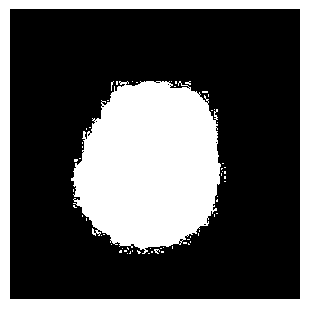

[2023-10-31 18:08:03] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [35]:
predicoes.show()